In [1]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [26]:
import numpy as np
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement

from grid_simulation import run_grid_simulation

### Pseudocode

(taken from L48 lectures) Fitting a gaussian process to a simulator using Emukit takes the following form:

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (expected improvement) -> new point(s)
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### User Function / Simulator
 
This is the function we want to understand. Namedly, how do parameters such as speed limit, traffic light timing, junction type and number of lanes per road, affect (1) the total carbon emissions generated by traffic in a road network, and (2) the average time it takes for vehicles to move through this network. 

*A complete list of parmeters analysed is discussed in our report.*

In [34]:
simulator = run_grid_simulation.Simulator()

def dummy_user_function(X):
    speed = X[:,0]
    num_lanes = X[:,1]
    traffic_light_time = X[:,2]
    
    CO = np.sin(speed)
    CO2 = np.cos(num_lanes)
    HC = np.tanh(traffic_light_time)
    
    return np.stack((CO, CO2, HC)).T
    
def user_function(*args):  # temporary whilst simulator in development
    simulator.simulate(gridSize=10, edgeMaxSpeed=50, numberOfLanes=2, *args)

### Model (GP)

Our surrogate model is our emulator. In this case, a gaussian process. Since we have both continuous and categorical inputs we convert categorical variables to their one-hot encoded counterparts. We want to predict multiple continuous outputs - fortunately GPy handles this for us.

#### Model Inputs

In [48]:
speed = ContinuousParameter('speed', min_value=0, max_value=70)
lanes = DiscreteParameter('lanes', domain=[1,2,3,4])
lights = ContinuousParameter('lights', min_value=10, max_value=100)

parameter_space = ParameterSpace([speed, lanes, lights])

#### Initialize Model / Emulator (GP)

In [49]:
design = RandomDesign(parameter_space)  # initialize with random points
num_data_points = 10
init_X = design.get_samples(num_data_points)
init_Y = dummy_user_function(init_X)

emulator = GPy.models.GPRegression(init_X, init_Y)
emukit_model = GPyModelWrapper(emulator)
emulator

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


### Optimization

#### Acquisition Function

In [50]:
expected_improvement = ExpectedImprovement(model=emukit_model)

#### Experimental Design

In [51]:
loop = ExperimentalDesignLoop(
    space = parameter_space, 
    model = emukit_model, 
    acquisition = expected_improvement
)

In [52]:
loop.run_loop(dummy_user_function, 30)

Optimization restart 1/1, f = 35.646497283942395
Optimization restart 1/1, f = 10.071924378155824
Optimization restart 1/1, f = 10.942991541148984
Optimization restart 1/1, f = 16.821061659102757
Optimization restart 1/1, f = 20.721853277315176
Optimization restart 1/1, f = 22.599133280241514
Optimization restart 1/1, f = 24.506369040320152
Optimization restart 1/1, f = 26.787686407941482
Optimization restart 1/1, f = 28.87548621440157
Optimization restart 1/1, f = 28.687617781748063
Optimization restart 1/1, f = 33.31450625029994
Optimization restart 1/1, f = 35.708538932363695
Optimization restart 1/1, f = 37.35404023942323
Optimization restart 1/1, f = 37.61562586695849
Optimization restart 1/1, f = 40.47385913891219
Optimization restart 1/1, f = 42.8288237889712
Optimization restart 1/1, f = 47.27677497236938
Optimization restart 1/1, f = 46.26729383263632
Optimization restart 1/1, f = 44.54215500337893
Optimization restart 1/1, f = 47.07163622005554
Optimization restart 1/1, f = 4

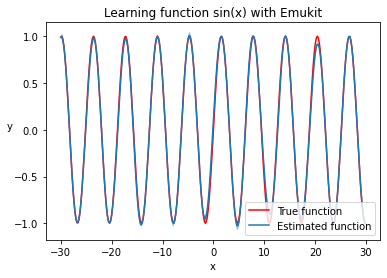

In [15]:
predicted_y = []
predicted_std = []

real_x = np.arange(0, 70, 0.2)
real_y = np.sin(real_x)

for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()
    
plt.title('Learning function sin(x) with Emukit')
plt.xlabel('x')
plt.ylabel('y', rotation=None)
plt.plot(real_x, real_y, c='r', )
plt.plot(real_x, predicted_y)
plt.legend(['True function', 'Estimated function'], loc='lower right')
plt.fill_between(real_x, predicted_y - 2 * predicted_std, predicted_y + 2 * predicted_std, alpha=.5);

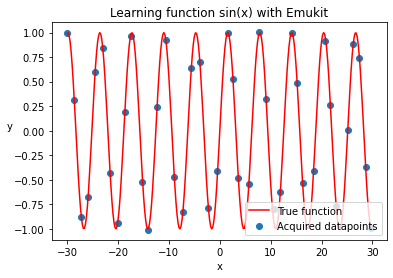

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

real_x = np.arange(x_min, x_max, 0.2)
real_y = np.sin(real_x)

plt.title('Learning function sin(x) with Emukit')
plt.xlabel('x')
plt.ylabel('y', rotation=None)
plt.plot(real_x, real_y, c='r')
plt.scatter(loop.loop_state.X[:, 0].tolist(), loop.loop_state.Y[:, 0].tolist());
plt.legend(['True function', 'Acquired datapoints'], loc='lower right');

### Scratch

In [ ]:
laneType is the same as numLanes